In [1]:
# Load required packages
library(dplyr,warn.conflicts=F)
library(stringr,warn.conflicts=F)
library(psych,warn.conflicts=F)
library(lplyr,warn.conflicts=F)

In [2]:
# load the stats
data.tourney <- readRDS('datafiles_rds/NCAATourneyDetailedResults.rds')
# keep 2014+
data.tourney %>% filter(Season>2013) -> data.tourney

In [3]:
# store 68 tourney teams 
data.tourney %>% 
    select(Season,TeamID=WTeamID) %>% 
    bind_rows(data.tourney %>% 
              select(Season,TeamID=LTeamID)) %>% 
    distinct(Season,TeamID) -> df.tourneyteams

In [4]:
# DunkleIndex Rating 2014+
# http://dunkelindex.com/rankings/basketball/ncaa/
data.dunkel <- read.csv('datafiles_csv/DunkelIndexMarch.csv',stringsAsFactors=F)
data.dunkel %>% head

Season,Rank,Team,Rating,Record,Conference
2018,1,Virginia,84.542,31-2,ACC
2018,2,Villanova,84.479,30-avr,Big East
2018,3,Michigan State,82.531,29-avr,Big Ten
2018,4,Cincinnati,82.235,30-avr,American
2018,5,Duke,82.178,26-juil,ACC
2018,6,Michigan,81.506,28-juil,Big Ten


In [5]:
data.dunkel %>% rename(Name=Team) -> data.dunkel

In [6]:
# load team spellings variations
data.teamspellings <- readRDS('datafiles_rds/TeamSpellings.rds')
data.teams <- readRDS('datafiles_rds/Teams.rds')

In [7]:
# add TeamID based on team name
data.dunkel %>% 
    mutate(LowName=str_to_lower(Name)) %>% 
    left_join(data.teamspellings,by=c('LowName'='TeamNameSpelling')) -> df.dunkel

In [8]:
data.dunkel %>% filter(str_detect(Name,'East\\.{0,1} Washington'))

Season,Rank,Name,Rating,Record,Conference
2018,128,East. Washington,58.732,20-14,Big Sky
2017,153,East Washington,55.793,22-nov,Big Sky
2016,214,East. Washington,48.952,17-15,Big Sky
2015,123,East. Washington,58.154,26-sept,Big Sky
2014,209,East. Washington,50.047,15-16,Big Sky


In [9]:
# missing tourney team in Dunkle stats (because name misspelling)
df.dunkel %>% 
    right_join(df.tourneyteams,by='TeamID') %>%
    filter(is.na(Rank)) %>%
    select(TeamID) %>%
    inner_join(data.teams,by='TeamID') %>%
    distinct() %>%
    arrange(TeamID)

TeamID,TeamName,FirstD1Season,LastD1Season
1114,Ark Little Rock,1985,2019
1142,Cal Poly SLO,1995,2019
1167,CS Bakersfield,2008,2019
1168,CS Fullerton,1985,2019
1186,E Washington,1985,2019
1192,F Dickinson,1985,2019
1291,Mt St Mary's,1989,2019
1385,St John's,1985,2019
1386,St Joseph's PA,1985,2019
1387,St Louis,1985,2019


In [10]:
# add missing TeamID from Sagarin stats
df.dunkel %>%
    mutate_which(str_detect(Name,'AR-Little Rock'),TeamID=1114) %>%
    mutate_which(str_detect(Name,'CalPoly'),TeamID=1142) %>%
    mutate_which(str_detect(Name,'CS-Bakersfield'),TeamID=1167) %>%
    mutate_which(str_detect(Name,'CS-Fullerton'),TeamID=1168) %>%
    mutate_which(str_detect(Name,'East\\.{0,1} Washington'),TeamID=1186) %>%
    mutate_which(str_detect(Name,'Fair Dickinson'),TeamID=1192) %>%
    mutate_which(str_detect(Name,'Mt. St. Mary'),TeamID=1291) %>%
    mutate_which(str_detect(Name,'St. John'),TeamID=1385) %>%
    mutate_which(str_detect(Name,'St. Louis'),TeamID=1387) %>%
    mutate_which(str_detect(Name,'St. Joseph'),TeamID=1386) %>%
    mutate_which(str_detect(Name,'^St. Mary'),TeamID=1388) %>%
    mutate_which(str_detect(Name,'LA-Lafayette'),TeamID=1418) %>%               # ULL University of Louisiana at Lafayette 
    mutate_which(str_detect(Name,'MD-Baltimore Co.'),TeamID=1420) %>%  # UMBC University Maryland Baltimore County
    mutate_which(str_detect(Name,'UNC-Greensboro'),TeamID=1422) %>%
    mutate_which(str_detect(Name,'UNC-Wilmington'),TeamID=1423) %>%
    mutate_which(str_detect(Name,'WI-Green Bay'),TeamID=1453) %>%
    mutate_which(str_detect(Name,'WI-Milwaukee'),TeamID=1454) -> df.dunkel

In [11]:
# check if ssomething is still wrong
df.dunkel %>% 
    right_join(df.tourneyteams,by='TeamID') %>%
    filter(is.na(Rank)) %>%
    select(TeamID) %>%
    inner_join(data.teams,by='TeamID') %>%
    distinct() %>%
    arrange(TeamID)

TeamID,TeamName,FirstD1Season,LastD1Season


In [12]:
# restrict stats to tourney teams
df.dunkel %>% 
    inner_join(df.tourneyteams,by=c('TeamID','Season')) %>%
    select(Season,TeamID,Rating) -> df.dunkel

In [13]:
# Check if we have 68 teams per Season
df.dunkel %>% 
    group_by(Season) %>% 
    count

Season,n
2014,68
2015,68
2016,68
2017,68
2018,68


In [14]:
# check missing TeamID per Season 
df.tourneyteams %>% 
    anti_join(df.dunkel,by=c('Season','TeamID'))

Season,TeamID


In [15]:
# compute the Truth 
data.tourney %>% 
    select(Season,WTeamID,LTeamID) %>% 
    mutate(TeamID.1=ifelse(WTeamID<LTeamID,WTeamID,LTeamID),
           TeamID.2=ifelse(WTeamID>LTeamID,WTeamID,LTeamID)) %>%
    mutate(ID=str_c(Season,'_',TeamID.1,'_',TeamID.2)) %>% 
    mutate(Target=ifelse(WTeamID==TeamID.1,1,0)) %>% 
    select(ID,Target) -> df.truth
df.truth %>% sample_n(5)

ID,Target
2017_1190_1196,0
2015_1412_1417,0
2017_1112_1315,1
2016_1112_1455,0
2015_1277_1438,1


In [16]:
# slope hyper parameter grid : we will compute 51 models and chose the best one (min logloss)
df.dunkel %>% 
    mutate(dummy=1) %>% 
    inner_join(data.frame(qtl=seq(0.01,0.99,0.01),dummy=1),by='dummy') %>% 
    select(-dummy) %>% 
    group_by(qtl,Season) %>% 
    mutate(thres=max(Rating)-quantile(Rating,max(qtl)),Slope=3/thres) %>%
    ungroup %>% 
    select(Season,qtl,Slope) %>% 
    distinct() -> df.dunkel.slopes
df.dunkel.slopes %>% sample_n(5)

Season,qtl,Slope
2014,0.15,0.1114719
2017,0.95,0.5035416
2018,0.47,0.2002601
2014,0.94,0.5299492
2017,0.72,0.2556716


In [18]:
# matchups dataframe : all the possible matches between the 68 teams per Season 
df.dunkel %>% 
    inner_join(df.dunkel,by='Season') %>% 
    filter(TeamID.x < TeamID.y) -> df.matchups
df.matchups %>% sample_n(5)

Season,TeamID.x,Rating.x,TeamID.y,Rating.y
2015,1326,71.872,1328,74.804
2016,1292,63.281,1332,81.896
2018,1139,72.324,1326,76.283
2015,1372,72.321,1452,72.810
2016,1233,66.171,1333,66.890


In [19]:
# all matchs with all 51 hyper parameter setting (qtl=[0.25,0.75]) 
df.matchups %>% inner_join(df.dunkel.slopes,by=c('Season')) -> df.matchups
df.matchups %>% sample_n(5)

Season,TeamID.x,Rating.x,TeamID.y,Rating.y,qtl,Slope
2014,1203,68.251,1438,80.475,0.30,0.1602145
2017,1274,73.108,1276,77.408,0.60,0.2052208
2014,1273,63.601,1409,65.708,0.99,3.3666255
2017,1153,78.459,1243,66.611,0.33,0.1482813
2018,1153,82.235,1328,66.631,0.57,0.2142413


In [20]:
# machups predictions : compute the winning probability of TeamID.x and cap it into [0.05,0.95] to avoid too much logloss is case of FP or FN 
df.matchups %>% 
    mutate(ID=str_c(Season,'_',TeamID.x,'_',TeamID.y)) %>% 
    mutate(Prob=logistic(Rating.x-Rating.y,a=Slope)) %>% 
    mutate(Pred=ifelse(Prob>0.5,1,0)) %>% 
    mutate(Prob=round(Prob,3)) %>%
    mutate_which(Prob>0.95,Prob=0.95) %>%
    mutate_which(Prob<0.05,Prob=0.05) %>%
    select(qtl,ID,Pred,Prob) -> df.submit
df.submit %>% sample_n(5)

qtl,ID,Pred,Prob
0.15,2015_1264_1323,0,0.115
0.32,2017_1233_1266,0,0.099
0.96,2016_1277_1328,1,0.950
0.02,2016_1214_1425,0,0.196
0.75,2016_1173_1451,1,0.915


In [21]:
# merge prediction and truth
df.truth %>% inner_join(df.submit,by='ID') -> df.results

In [22]:
# compute accuracy & Logloss per qtl to find the best one
df.results %>% 
    mutate(OK=ifelse(Pred==Target,1,0)) %>%
    mutate(LogLoss=Target*log(Prob) + (1-Target)*log(1-Prob)) %>%
    group_by(qtl) %>%
    summarise(TC=sum(OK),N=n(),FC=N-TC,Acc=TC/N,LogLoss=-mean(LogLoss)) %>%
    select(qtl,TC,FC,N,Acc,LogLoss) -> df.results.perf
df.results.perf %>% arrange(LogLoss) %>% head(5)

qtl,TC,FC,N,Acc,LogLoss
0.20,247,88,335,0.7373134,0.5363770
0.23,247,88,335,0.7373134,0.5364130
0.24,247,88,335,0.7373134,0.5364156
0.19,247,88,335,0.7373134,0.5364732
0.25,247,88,335,0.7373134,0.5364756


In [24]:
library(ggplot2,warn.conflicts=F)

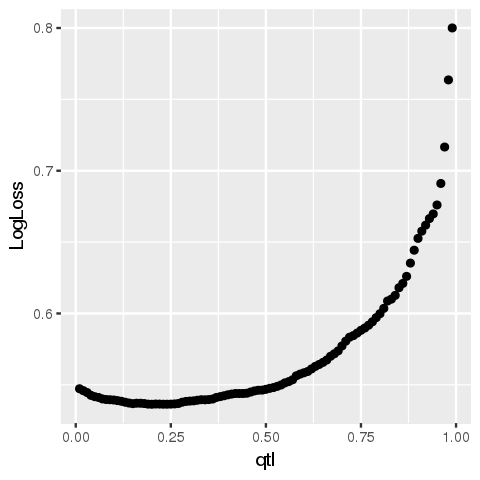

In [25]:
options(repr.plot.width=4, repr.plot.height=4)
qplot(data=df.results.perf,x=qtl,y=LogLoss)

In [23]:
# store the best qtl
df.results.perf %>% 
    arrange(LogLoss) %>% 
    head(1) %>% pull(qtl) -> bestqtl